# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

In [24]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np
from n2gem.metrics import gem_build_coverage, gem_build_density
from sklearn.model_selection import train_test_split

In [2]:
import torchvision
from fastai.vision.all import *

Fix the seed generator

In [3]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device); print(torch.cuda.memory_allocated())
torch.cuda.device_count()

cuda
0


1

### Import the MNIST dataset 

In [5]:
def load_mnist():
    """Function to load the mnist
        The foolowing transform is aaplied: Normalize:(0.1307,)(0.3081,)
    
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081))
    ])
    train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
    test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)
    
    return train_set, test_set

train_set, test_set = load_mnist()

### Combine the datasets and stratify split 
- Combine train and test
- form the model_dataset[training+ test] and validation set
- obtain training & test set to train on the model from model_dataset

In [7]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split

def create_dataset(train_set, test_set, vali_split, test_split):
    """Function to split the dataset and form the training, test and validation datasets
        
        Parameters
        ----------------------
        train_set: torch.utils.mnist.dataset
        test_set: torch.utils.mnist.dataset
        vali_split: the size for the validation set 
        test_split: the size of the test set
        
        Return
        ----------------------
        X_trainset: list, size: train_size, 1, 28, 28
        X_testset: list, size: test_size, 1, 28, 28
        X_validation: list, size: vali_size, 1, 28, 28
        y_trainset: list, size: train_size
        y_testset: list, size: test_size
        y_valiset: list, size: vali_size
        
    """
    # combine the datasets
    dataset = ConcatDataset([train_set, test_set])
    X=[]; Y=[];
    for i in range(len(dataset)):
        x, y = dataset[i]
        X.append(x.numpy())  #.detach().cpu().numpy())
        Y.append(y)
    
    # split the dataset into train and validation set
    X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=vali_split, random_state=42, stratify=np.array(Y))

    print("X_validation_set size: ", np.array(X_validation).shape)
    print("Y_validation_set size: ", len(y_validation))

    
    # split the X_model, y_model into training set & test set
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_model, y_model, test_size=test_split, random_state=42, stratify=np.array(y_model))
    print("X_train_set size: ", np.array(X_trainset).shape)
    print("Y_train_set size: ", len(y_trainset))
    print("X_test_set size: ", np.array(X_testset).shape)
    print("Y_test_set size: ", len(y_testset))
    
    #X = np.array(X); Y = np.array(Y)
    
    return X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation

X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(train_set, test_set, 0.03, 0.2)

X_validation_set size:  (2100, 1, 28, 28)
Y_validation_set size:  2100
X_train_set size:  (54320, 1, 28, 28)
Y_train_set size:  54320
X_test_set size:  (13580, 1, 28, 28)
Y_test_set size:  13580


### Convert the datasets to Torch.TensorDataset

In [8]:
def convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation):
    """
    Function to convert the split datasets into torch Tensor dataset
    
    Parameters
    ----------------------
    X_trainset: list, size: train_size, 1, 28, 28
    X_testset: list, size: test_size, 1, 28, 28
    X_validation: list, size: vali_size, 1, 28, 28
    y_trainset: list, size: train_size
    y_testset: list, size: test_size
    y_valiset: list, size: vali_size
    
    Return
    -------------------
    train_set: TensorDataset, consists of training images and labels
    test_set: TensorDataset, consists of test images and labels
    validation_set: TensorDataset, consists of validation images and labels
    
    # for the adversarial attack
    model_dataset_images: Tensor, size: (training + test) size, only the images
    model_dataset_images: Tensor, size: (training + test) size, only the labels
    """
    X_trainset = torch.Tensor(X_trainset); 
    y_trainset = torch.Tensor(y_trainset).type(torch.LongTensor) #dtype = torch.long);
    X_testset = torch.Tensor(X_testset); 
    y_testset = torch.Tensor(y_testset).type(torch.LongTensor);
    X_validation = torch.Tensor(X_validation); 
    y_validation = torch.Tensor(y_validation).type(torch.LongTensor)
    # y - label should be longTensor for fastai training
    
    # form model_dataset
    model_dataset_images = torch.vstack((X_trainset, X_testset))
    model_dataset_labels = torch.cat((y_trainset, y_testset))
    
    # form the Tensor dataset
    train_set = torch.utils.data.TensorDataset(X_trainset, y_trainset)
    test_set = torch.utils.data.TensorDataset(X_testset, y_testset)
    validation_set = torch.utils.data.TensorDataset(X_validation, y_validation)
    
    return train_set, test_set, validation_set, model_dataset_images, model_dataset_labels

train_set, test_set, validation_set, model_images, model_labels = convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation)

In [21]:
torch.save(model_images, 'model_dataset_images.pt')
torch.save(model_labels, 'model_dataset_labels.pt')

In [22]:
torch.save(X_validation, 'validation_images.pt')
torch.save(y_validation, 'validation_labels.pt')

### The Dataloader for the CNN models

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

### Define the CNN model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [5]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

### Fastai classifier
- Fastai takes the available device by default

In [11]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

- Initial fit for the model

In [12]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.168212,0.113628,0.964065,00:05
1,0.095370,0.060073,0.981002,00:03
2,0.072611,0.048427,0.985125,00:03


- Unfreeze and check the optimal learning rate

SuggestedLRs(valley=tensor(3.3113e-06))

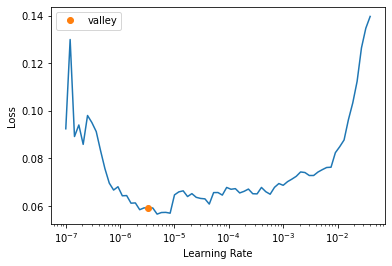

In [13]:
learn.unfreeze()
learn.lr_find()

- Fit the model again

In [14]:
learn.fit_one_cycle(8, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.071336,0.048203,0.985125,00:03
1,0.061386,0.047559,0.984904,00:03
2,0.062562,0.046872,0.984904,00:03
3,0.071075,0.046369,0.985125,00:03
4,0.061507,0.046122,0.985346,00:03
5,0.065839,0.046019,0.985420,00:03
6,0.063768,0.046045,0.985641,00:03
7,0.062972,0.046035,0.985641,00:03


In [16]:
#learn.recorder.plot_loss()

- Fine tune the model 

In [17]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.120263,0.065498,0.979750,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.064480,0.040627,0.987629,00:03
1,0.069494,0.044321,0.986230,00:03
2,0.051842,0.032422,0.989691,00:03
3,0.047426,0.030197,0.991090,00:03
4,0.035231,0.029030,0.991164,00:03


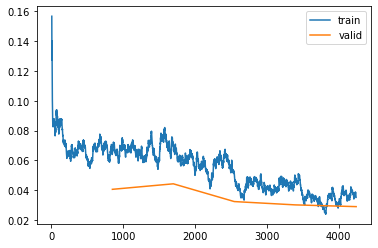

In [18]:
learn.recorder.plot_loss()

### - Save the fastai classifier
- By default it is saved in the /models folder with .pth extension

In [23]:
learn.save('./fastai_cnn_NewNet_99_splitDataset')

Path('models/fastai_cnn_NewNet_99_splitDataset.pth')

- Load the model(fastai) and save it as torch model for foolbox compatibility

In [24]:
model_new = learn.load('fastai_cnn_NewNet_99_splitDataset')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_splitDataset_weights.pth')

### Load model for the attack

In [6]:
# load the NewNet model
MyModel = NewNet()
MyModel.load_state_dict(torch.load('chkpt_files/fastai_cnn_NewNet_99_splitDataset_weights.pth', map_location=device))
MyModel.eval()
print(torch.cuda.memory_allocated())
# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

0


### Create a Pytorch model for foolbox attack

In [7]:
preprocess = dict(mean=0.1307, std=0.3081)
bound = (0, 1)
original_model = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

- Three different attacks with 100 values of epsilons

In [8]:
attack0 = fb.attacks.LinfPGD()
attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=20)

- Attack the ```trained network``` with model_dataset

In [9]:
def model_attack(attk, model, image, label, epsilon):
    """
    Function to perform the adv attack on the pytorch model
    
    Parameters
    --------------------
    attk: type of foolbox attack
    model: foolbox Pytorch model
    image: the images used for the attack, either as ep.tensor or torch.tensor
            size:(no_of_samples x dims)
    labels: corresponding labels for the images, either as ep.tensor or torch.tensor
            size:(no_of_samples 
    epsilon: the pertubation
    
    Return
    -------------
    clip_adv: list, the actual adversarial examples generated for the given model
                size: similar to the input images
    adv_ : boolean list, indicating whether a given image is adversarial example or not,
            True - adversarial sample
            False - not an adversarial sample
    """
    raw_adv, clip_adv, adv_ = attk(model, images, labels, epsilons=epsilon)
    
    return clip_adv, adv_


## Attack the model using 20 epsilon & ```FGSM attack```

- Attack the model using model_dataset, using only 20000 images
- The 20000 images is selected using stratify split

#### Load the the images

In [10]:
md_images = torch.load('images/model_dataset_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/model_dataset_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/validation_labels.pt', map_location='cpu')

In [23]:
print(np.unique(md_labels.cpu().numpy(), return_counts=True))
print(np.unique(np.array(vali_labels), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6696, 7641, 6780, 6927, 6619, 6124, 6670, 7074, 6620, 6749]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([207, 236, 210, 214, 205, 189, 206, 219, 205, 209]))


- split the model_dataset to obtain 20000 images

In [27]:
# split the model_dataset to obtain 20000 images for the attack
_, X_images, _, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.29455, random_state=42, stratify=md_labels.numpy())

In [36]:
print(np.unique(np.array(y_labels), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1972, 2251, 1997, 2040, 1949, 1804, 1965, 2084, 1950, 1988]))


In [29]:
images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device))
labels = ep.astensor(torch.from_numpy(np.array(y_labels)).to(device))

In [30]:
adv_images, adv_info = model_attack(attack2, original_model, images, labels, epsilon)

#### Plot the results

Text(0.5, 1.0, 'The NewNet Model with FGSM attack')

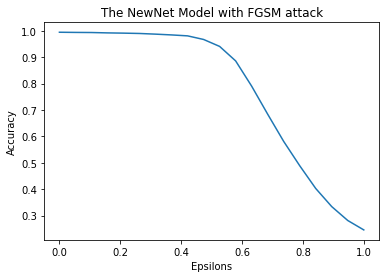

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)
ax.plot(epsilon, robust_accuracy)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with FGSM attack")

### Metrics

In [37]:
def model_metrics(adv_imgs, real_imgs, epi_len):
    """
    Function to compute density & coverage for the between the 
    real & adversarial samples
    
    Parameters
    ---------------
    adv_imgs: ep.tensor, the generated adversarial samples, size: no_of_images x image_dims
    real_imgs: torch.tensor, size: no_of_images x dims
    epi_len: integer, the length or number of epsilons used for the attack
    """
    density = []
    coverage = []
    if not epi_len==1:
        for i in range(epi_len):
            # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
            gen = adv_imgs[i].raw.view(adv_imgs[i].shape[0], -1).cpu()

            # density
            density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

            # coverage
            coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
    else:
        gen = adv_imgs.raw.view(adv_imgs.shape[0], -1).cpu()

        # density
        density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

        # coverage
        coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
        
    return density, coverage

### - density & coverage for

#### --> model_dataset & adversarial samples 

In [38]:
# resize the real images
real = images.raw.view(images.shape[0], -1)

# 20 values of epsilons were considered
# find the density & coverage for each vgalue of epsilons
density = []
coverage = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_images[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    density.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    coverage.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

#### --> model_dataset & validation set

In [40]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).to(device)
gen_labels = torch.from_numpy(np.array(vali_labels)).to(device)
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(0.9972, device='cuda:0') tensor(0.3916, device='cuda:0')


#### Attack the model using validation dataset

In [41]:
adv_vali, adv_info_vali = model_attack(attack2, original_model, gen_validate, gen_labels, epsilon)

#### --> model_dataset and validation adversarial samples

In [42]:
vali_den = []
vali_cov = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_vali[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [54]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
density_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Model_adv_density: {:.5f}, Vali_adv_density: {:.5f}".format(epsilon[i], robust_accuracy[i], density[i], vali_den[i]))
    density_data.append([epsilon[i], robust_accuracy[i], density[i].cpu().numpy(), vali_den[i].cpu().numpy()])

density_data = np.array(density_data)

Density
Model_dataset & validation set: density: 0.99724
Epsilon: 0.00000, Accuracy: 0.99%, Model_adv_density: 1.09794, Vali_adv_density: 1.09794
Epsilon: 0.05263, Accuracy: 0.99%, Model_adv_density: 1.39155, Vali_adv_density: 1.39155
Epsilon: 0.10526, Accuracy: 0.99%, Model_adv_density: 1.48934, Vali_adv_density: 1.48934
Epsilon: 0.15789, Accuracy: 0.99%, Model_adv_density: 1.48173, Vali_adv_density: 1.48173
Epsilon: 0.21053, Accuracy: 0.99%, Model_adv_density: 1.36783, Vali_adv_density: 1.36783
Epsilon: 0.26316, Accuracy: 0.99%, Model_adv_density: 1.15994, Vali_adv_density: 1.15994
Epsilon: 0.31579, Accuracy: 0.99%, Model_adv_density: 0.91074, Vali_adv_density: 0.91074
Epsilon: 0.36842, Accuracy: 0.98%, Model_adv_density: 0.67030, Vali_adv_density: 0.67030
Epsilon: 0.42105, Accuracy: 0.98%, Model_adv_density: 0.47672, Vali_adv_density: 0.47672
Epsilon: 0.47368, Accuracy: 0.97%, Model_adv_density: 0.44748, Vali_adv_density: 0.44748
Epsilon: 0.52632, Accuracy: 0.94%, Model_adv_density:

Text(0.5, 1.0, 'The NewNet Model with FGSM attack')

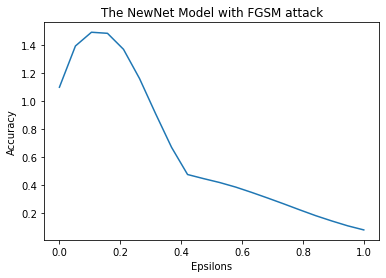

In [44]:
fig, ax = plt.subplots()
ax.plot(epsilon, density)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with FGSM attack")

In [56]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_validate}")
print(f"Model_dataset & adversarial samples")
coverage_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Model_adv_coverage: {:.5f}, Vali_adv_coverage: {:.5f}".format(epsilon[i], robust_accuracy[i], coverage[i], vali_cov[i]))
    coverage_data.append([epsilon[i], robust_accuracy[i], coverage[i].cpu().numpy(), vali_cov[i].cpu().numpy()])

coverage_data = np.array(coverage_data)

Coverage
Model_dataset & validation set: coverage: 0.39159998297691345
Model_dataset & adversarial samples
Epsilon: 0.00000, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.05263, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.10526, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.15789, Accuracy: 0.99%, Model_adv_coverage: 0.99995, Vali_adv_coverage: 0.99995
Epsilon: 0.21053, Accuracy: 0.99%, Model_adv_coverage: 0.98955, Vali_adv_coverage: 0.98955
Epsilon: 0.26316, Accuracy: 0.99%, Model_adv_coverage: 0.94520, Vali_adv_coverage: 0.94520
Epsilon: 0.31579, Accuracy: 0.99%, Model_adv_coverage: 0.91540, Vali_adv_coverage: 0.91540
Epsilon: 0.36842, Accuracy: 0.98%, Model_adv_coverage: 0.90040, Vali_adv_coverage: 0.90040
Epsilon: 0.42105, Accuracy: 0.98%, Model_adv_coverage: 0.88385, Vali_adv_coverage: 0.88385
Epsilon: 0.47368, Accuracy: 0.97%, Model_adv_coverage: 0.87155, Vali_adv_c

- save/write the density_data & coverage_data
- info: attack model with model_dataset -> model_dataset & adversarial samples
- attack model validataion_dataset -> model_dataset & vali_adv samples
- model_dataset & vali_dataset

In [87]:
with open('FGSM_attack_density.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(20000 images)" + "\n" +
                 "# and valiudation_images(2100) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy Model_adv_density Vali_adv_density" + "\n" +
                 "# Model_dataset & validation set: " + str(density_validate.cpu().numpy()) + "\n" )

with open('FGSM_attack_coverage.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(20000 images)" + "\n" +
                 "# and valiudation_images(2100) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy Model_adv_coverage Vali_adv_coverage" + "\n" +
                 "# Model_dataset & validation set: " + str(coverage_validate.cpu().numpy()) + "\n")
with open('FGSM_attack_density.dat', 'a') as addfile:
    np.savetxt(addfile, density_data)
    
with open('FGSM_attack_coverage.dat', 'a') as addfile:
    np.savetxt(addfile, coverage_data)

## Attack the model using 5 epsilon & ```Boundary attack```

#### Attack the model using ```model_dataset```

- Load the model_dataset & validation dataset

In [7]:
md_images = torch.load('images/model_dataset_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/model_dataset_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/validation_labels.pt', map_location='cpu')
#print(torch.cuda.memory_allocated())

In [8]:
images = ep.astensor( md_images[:20000, :, :, :].to(device))
labels = ep.astensor(md_labels[:20000].to(device))

In [14]:
del md_images; del md_labels; del images; del labels

In [10]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

64871424


#### Attack the model

In [12]:
epi = np.linspace(0.0, 1.0, 5)
attak = fb.attacks.BoundaryAttack()
_, adv_bdy_images, adv_bdy_info = attak(original_model, images, labels, epsilons=epi)

Plot the results

Text(0.5, 1.0, 'The NewNet Model with Boundary attack')

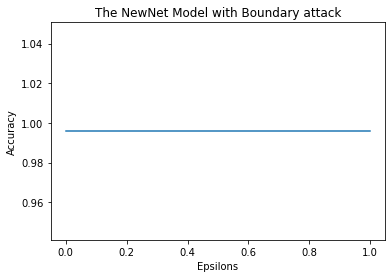

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
robust_accuracy = []
for i in range(len(epi)):
    acc = 1 - adv_bdy_info[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)
ax.plot(epi, robust_accuracy)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with Boundary attack")

### Metrics

#### model_dataset & adversarial samples

In [60]:
real = images.raw.view(images.shape[0], -1).cpu()
model_bdy_attk_density, model_bdy_attk_coverage = model_metrics(adv_bdy_images, real, len(epi))

#### model_dataset & validation dataset

In [63]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).cpu()
gen_labels = torch.from_numpy(np.array(vali_labels)).cpu()

In [64]:
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')

In [69]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))
vali_attk_images.shape, vali_attk_labels.shape

(torch.Size([2100, 1, 28, 28]), torch.Size([2100]))

#### Attack the model using validation set

In [70]:
_, adv_bdy_vali_images, adv_bdy_vali_info = attak(original_model, vali_attk_images, vali_attk_labels, epsilons=epi)

In [71]:
modelv_bdy_density, modelv_bdy_coverage = model_metrics(adv_bdy_vali_images, gen_validate, len(epi))

#### Print the results

In [72]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
for i in range(len(epi)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Model_adv_density: {:.5f}, Vali_adv_density: {:.5f}".format(epi[i], robust_accuracy[i], model_bdy_attk_density[i], modelv_bdy_density[i]))

Density
Model_dataset & validation set: density: 1.01076
Epsilon: 0.00000, Accuracy: 1.00%, Model_adv_density: 1.13520, Vali_adv_density: 1.09495
Epsilon: 0.25000, Accuracy: 1.00%, Model_adv_density: 1.25715, Vali_adv_density: 1.25200
Epsilon: 0.50000, Accuracy: 1.00%, Model_adv_density: 1.31539, Vali_adv_density: 1.30771
Epsilon: 0.75000, Accuracy: 1.00%, Model_adv_density: 1.37387, Vali_adv_density: 1.36381
Epsilon: 1.00000, Accuracy: 1.00%, Model_adv_density: 1.43164, Vali_adv_density: 1.42352


In [74]:
print("Coverage")
print(f"Model_dataset & validation set: Coverage: {coverage_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
for i in range(len(epi)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Model_adv_coverage: {:.5f}, Vali_adv_coverage: {:.5f}".format(epi[i], robust_accuracy[i], model_bdy_attk_coverage[i], modelv_bdy_coverage[i]))

Coverage
Model_dataset & validation set: Coverage: 0.39365
Epsilon: 0.00000, Accuracy: 1.00%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.25000, Accuracy: 1.00%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.50000, Accuracy: 1.00%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.75000, Accuracy: 1.00%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 1.00000, Accuracy: 1.00%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000


In [43]:
#del images; del labels; del MyModel;
#torch.cuda.empty_cache(); print(torch.cuda.memory_allocated())

## Attack the model using ```HOP_Skip_Jump_attack``` aka BoundaryAttack++

In [21]:
attack = fb.attacks.HopSkipJump(steps=0, initial_gradient_eval_steps=10, max_gradient_eval_steps=1000)
_, hsj_attk_images, hsj_attk_info = attack(original_model, images, labels, epsilons=None)

### Metrics

#### -> model_dataset & adv samples

In [34]:
real = images.raw.view(images.shape[0], -1).cpu()
model_hsj_attk_density, model_hsj_attk_coverage = model_metrics(hsj_attk_images, real, 1)

#### -> model_dataset & validation_set

In [29]:
# images from the validation set
gen_hsj_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).cpu()
gen_hsj_labels = torch.from_numpy(np.array(vali_labels)).cpu()

In [30]:
density_hsj_validate = gem_build_density(real, real.shape[0], gen_hsj_validate, 'indexflatl2')
coverage_hsj_validate = gem_build_coverage(real, real.shape[0], gen_hsj_validate, 'indexflatl2')

In [31]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))

#### Attack model using validation_dataset

In [32]:
_, adv_bdy_vali_images, adv_bdy_vali_info = attack(original_model, vali_attk_images, vali_attk_labels, epsilons=None)

In [33]:
modelv_hsj_density, modelv_hsj_coverage = model_metrics(adv_bdy_vali_images, gen_hsj_validate, 1)

#### Print the results

In [40]:
print("Density")
print(f"Model_dataset & validation set: density: {density_hsj_validate:.5f}")

print(f"Model_adv_density: {model_hsj_attk_density[0]:.5f}, Vali_adv_density: {modelv_hsj_density[0]:.5f}")

Density
Model_dataset & validation set: density: 1.01076
Model_adv_density: 0.00717, Vali_adv_density: 0.06762


In [41]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_hsj_validate:.5f}")

print(f"Model_adv_density: {model_hsj_attk_coverage[0]:.5f}, Vali_adv_density: {modelv_hsj_coverage[0]:.5f}")

Coverage
Model_dataset & validation set: coverage: 0.39365
Model_adv_density: 0.02905, Vali_adv_density: 0.09524


## The End